In [1]:
using Plots, JLD, OffsetArrays, LinearAlgebra, ConfParser, ProgressMeter, Colors, Statistics,
    EllipsisNotation, Images, FFTW, Retry
import OffsetArrays: no_offset_view

In [119]:
function generateConfig(params)
    k, uf, fs_radius, λ₁, λ₂, λ₃, randomize_4D, restart = params
    open("measurements/trial_3/$k.conf", "w") do f
        write(f, """
N                     1000
undersampling_rate    $uf
fully_sampled_radius  $fs_radius
lambda_1              $λ₁
lambda_2              $λ₂
lambda_3              $λ₃
randomize_4D          $randomize_4D
restart               $restart
verbose               true
        """)
    end
end

generateConfig (generic function with 1 method)

In [120]:
uf_r_combinations = []
for uf in 0.1:0.1:0.9
    for r in 0.05:max(0.05, uf/4):uf/4*3
        push!(uf_r_combinations, (uf, r))
    end
end
uf_r_combinations

25-element Array{Any,1}:
 (0.1, 0.05)
 (0.2, 0.05)
 (0.2, 0.1)
 (0.2, 0.15000000000000002)
 (0.3, 0.05)
 (0.3, 0.125)
 (0.3, 0.2)
 (0.4, 0.05)
 (0.4, 0.15000000000000002)
 (0.4, 0.25)
 (0.5, 0.05)
 (0.5, 0.175)
 (0.5, 0.3)
 (0.6, 0.05)
 (0.6, 0.2)
 (0.6, 0.35)
 (0.7, 0.05)
 (0.7, 0.22499999999999998)
 (0.7, 0.39999999999999997)
 (0.8, 0.05)
 (0.8, 0.25)
 (0.8, 0.45)
 (0.9, 0.05)
 (0.9, 0.275)
 (0.9, 0.5)

In [121]:
grid₁ = [(uf, r, 2e-5, 2e-5, 0.07, true, true) for (uf,r) in uf_r_combinations]
grid₁ = enumerate(vec(grid₁))
grid₁ = [(i, p...) for (i,p) in grid₁]
@show length(grid₁)

length(grid₁) = 25


25

In [122]:
grid₂ = [(uf, r, 1e-5, 1e-5, 0.035, true, true) for (uf,r) in uf_r_combinations]
grid₂ = enumerate(vec(grid₂))
grid₂ = [(i+length(grid₁), p...) for (i,p) in grid₂]
@show length(grid₂)

length(grid₂) = 25


25

In [123]:
log_range₁ = [1e-6, 1e-5, 1e-4]
log_range₂ = [0, 1e-3, 1e-2, 1e-1]
grid₃ = [(uf, r, λ₁, λ₂, λ₃, false, true) for (uf,r) in uf_r_combinations, λ₁ in log_range₁,
            λ₂ in log_range₁, λ₃ in log_range₂]
grid₃ = enumerate(vec(grid₃))
grid₃ = [(i+length(grid₁)+length(grid₂), p...) for (i,p) in grid₃]
@show length(grid₃)

length(grid₃) = 900


900

In [124]:
generateConfig.([grid₁..., grid₂..., grid₃...]);

## Evaluate results

In [64]:
d₁, d₂, d₃, m = 300, 224, 48, 4
kSpace_orig = Array{ComplexF32}(undef, d₁, d₂, d₃, m)
read!("../data.dat", kSpace_orig)
kSpace_orig = ntoh.(kSpace_orig) # big-endian to system default
kSpace = ComplexF64.(kSpace_orig)
image4D = ifft(kSpace, [1,2,3]);

In [65]:
image3D = mean(abs.(image4D), dims = 4)
image3D_norm = norm(image3D)
mse_temp = similar(image3D)
mse(img) = norm(mean!(mse_temp, abs.(img)) .-= image3D) / image3D_norm

mse (generic function with 1 method)

In [66]:
function imshow(img::Array{T, 2}; shift = false) where T<:Number
    plot(Gray.(abs.(img)'), seriestype=:image)
end

imshow (generic function with 1 method)

In [105]:
p = Progress(length(filter(x -> endswith(x, ".jld"), readdir("measurements/trial_3/"))), 1)
NMSE, cost = [[Dict() for _ in 1:9] for _ in 1:2]
foreach(readdir("measurements/trial_3/")) do f
    if endswith(f, ".jld")
        conf_filename = "measurements/trial_3/" * split(f, ".")[1] * ".conf"
        conf = ConfParse(conf_filename)
        parse_conf!(conf)
        undersampling_rate = parse(Float64, retrieve(conf, "undersampling_rate"))
        uf = round(Int, undersampling_rate * 10)
        r = parse(Float64, retrieve(conf, "fully_sampled_radius"))
        λ₁ = parse(Float64, retrieve(conf, "lambda_1"))
        λ₂ = parse(Float64, retrieve(conf, "lambda_2"))
        λ₃ = parse(Float64, retrieve(conf, "lambda_3"))
        try
            d = nothing
            @repeat 4 try
                d = jldopen("measurements/trial_3/"*f, "r") do file
                    (NMSE = read(file, "NMSE"), cost = read(file, "cost"))
                end
            catch e
                @delay_retry if true
                end
            end
            random = parse(Bool, retrieve(conf, "randomize_4D")) ? ", 4D rand" : ""
            NMSE[uf]["$(split(f, ".")[1]) | r: $(round(r, digits=2)), λ₁: $λ₁, λ₂: $λ₂, λ₃: $λ₃"*random] = d[:NMSE]
            cost[uf]["$(split(f, ".")[1]) | r: $(round(r, digits=2)), λ₁: $λ₁, λ₂: $λ₂, λ₃: $λ₃"*random] = d[:cost]
        catch
        end
        next!(p)
    end
end
finish!(p)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


In [106]:
best_label = ["" for _ in 1:9]
function compare(idx)
    minimal_values = Array{Tuple{String, Float64}}(undef, 0)
    for (label, series) in NMSE[idx]
        series[series .< series[0]/10] .= NaN
        series[findfirst(isnan, series):end] .= NaN
        any(x -> x > 1.5, series) && continue
        push!(minimal_values, (label, series[findfirst(isnan, series)-1]))
    end
    top_list = sort(minimal_values, lt = (x,y) -> x[2] < y[2])[1:15]
    for (label, _) in top_list
        plot!(NMSE[idx][label], label=label, title = "undersampling rate: 0.$idx",
            subplot = idx, legend = true, size=(800,3000))
    end
    best_label[idx] = top_list[1][1]
end

compare (generic function with 1 method)

In [107]:
plt = plot(layout = (9,1))
[compare(i) for i in 1:9]
plt

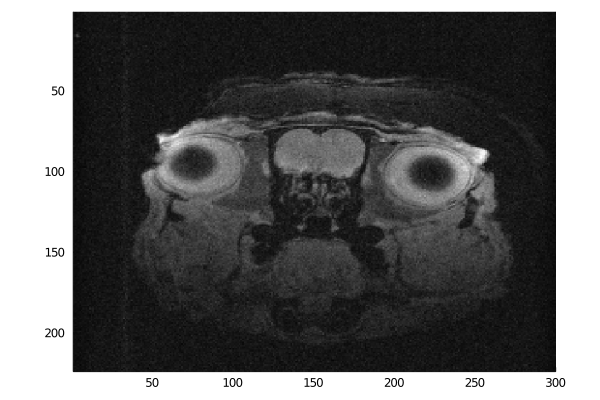

In [108]:
image3D_first_slice = mean(abs.(image4D), dims = 4)[..,24,1]
imshow(fftshift(image3D_first_slice, 1) ./ maximum(abs, image3D_first_slice))

In [109]:
function eval_result(fname)
    d = load(fname)
    image3D_pogm = mean(abs.(d["image4D"]), dims = 4)
    ssim = minimum([assess_ssim(image3D[..,i,1], image3D_pogm[..,i,1]) for i in 1:size(image3D, 3)])
    NMSE = mse(d["image4D"])
    plt = imshow(fftshift(image3D_pogm[..,24,1], 1) ./ maximum(image3D_pogm[..,24,1]))
    ssim, NMSE, plt
end

eval_result (generic function with 1 method)

ssim = 0.8855411518981993
NMSE = 0.2565434335226491


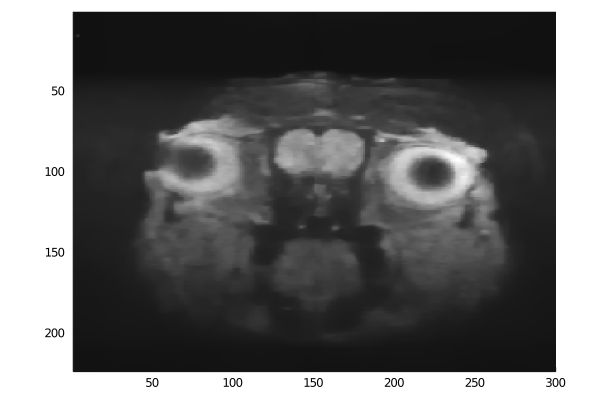

In [110]:
ssim, NMSE, plt = eval_result("measurements/trial_3/" * split(best_label[1], " ")[1] * ".jld")
@show ssim
@show NMSE
plt

ssim = 0.9176226163574
NMSE = 0.2107969747268332


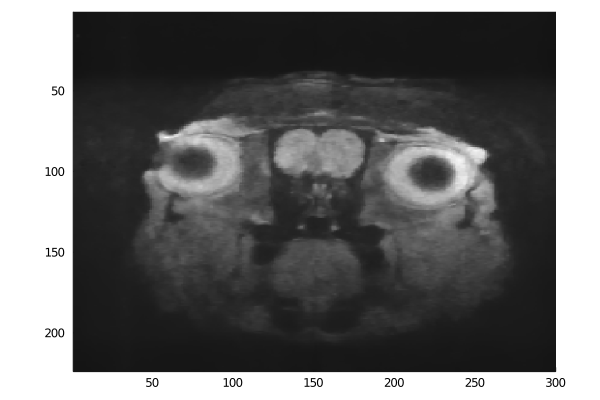

In [111]:
ssim, NMSE, plt = eval_result("measurements/trial_3/" * split(best_label[2], " ")[1] * ".jld")
@show ssim
@show NMSE
plt

ssim = 0.9276966591141211
NMSE = 0.19687347973256716


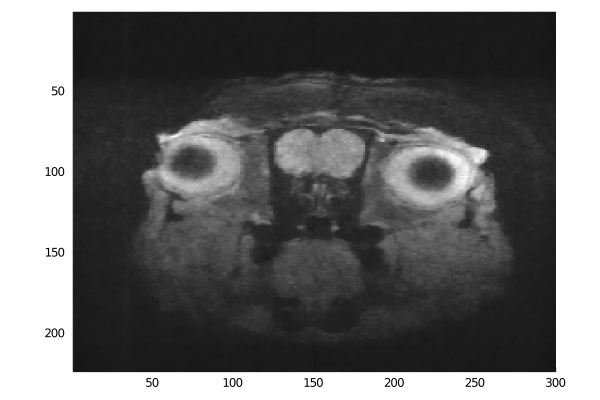

In [112]:
ssim, NMSE, plt = eval_result("measurements/trial_3/" * split(best_label[3], " ")[1] * ".jld")
@show ssim
@show NMSE
plt

ssim = 0.9397017155928248
NMSE = 0.17553210815773965


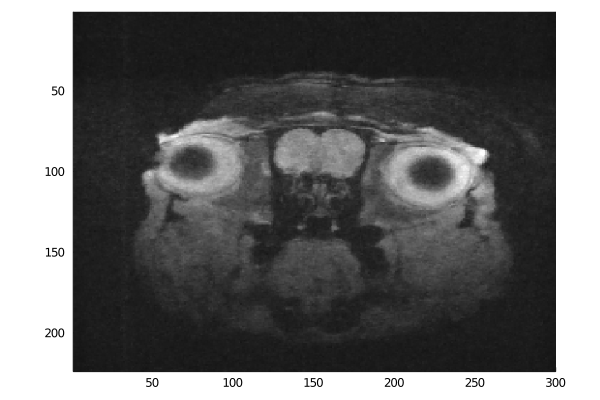

In [113]:
ssim, NMSE, plt = eval_result("measurements/trial_3/" * split(best_label[4], " ")[1] * ".jld")
@show ssim
@show NMSE
plt

ssim = 0.9532256448929419
NMSE = 0.15089637533049746


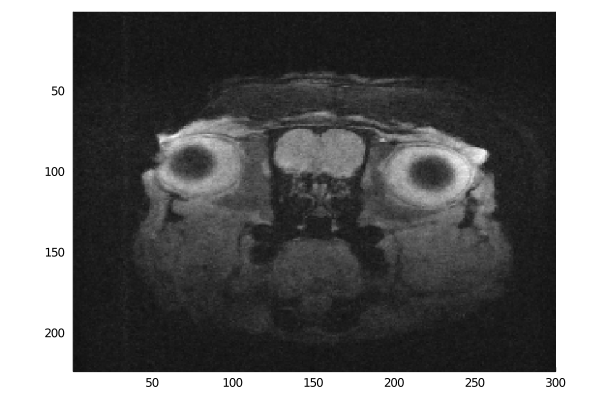

In [114]:
ssim, NMSE, plt = eval_result("measurements/trial_3/" * split(best_label[5], " ")[1] * ".jld")
@show ssim
@show NMSE
plt

ssim = 0.9652706151107001
NMSE = 0.12776688425624214


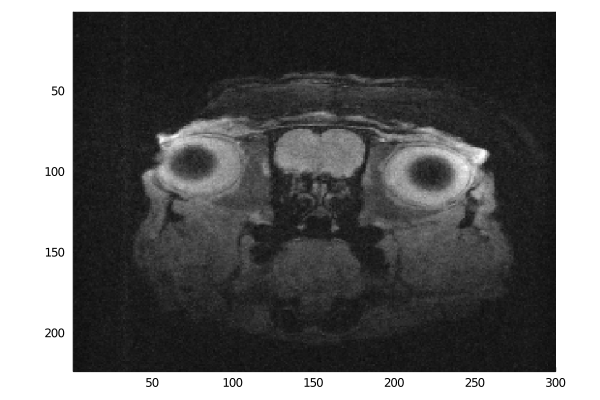

In [115]:
ssim, NMSE, plt = eval_result("measurements/trial_3/" * split(best_label[6], " ")[1] * ".jld")
@show ssim
@show NMSE
plt

ssim = 0.9783571896629701
NMSE = 0.09821815687340842


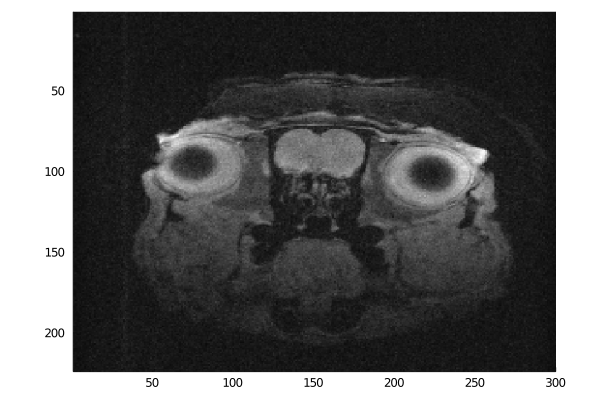

In [116]:
ssim, NMSE, plt = eval_result("measurements/trial_3/" * split(best_label[7], " ")[1] * ".jld")
@show ssim
@show NMSE
plt

ssim = 0.9889455038724034
NMSE = 0.06942721831852126


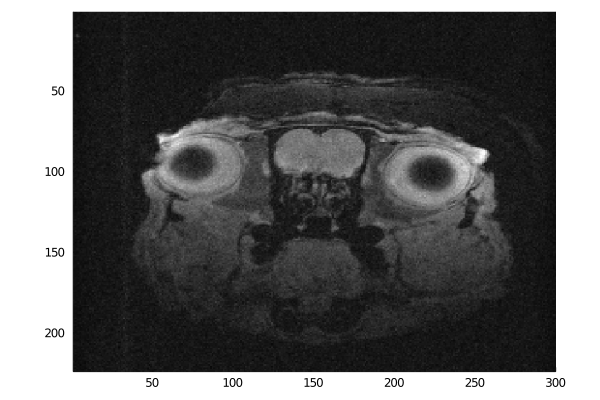

In [117]:
ssim, NMSE, plt = eval_result("measurements/trial_3/" * split(best_label[8], " ")[1] * ".jld")
@show ssim
@show NMSE
plt

ssim = 0.990294441057764
NMSE = 0.06414271685273085


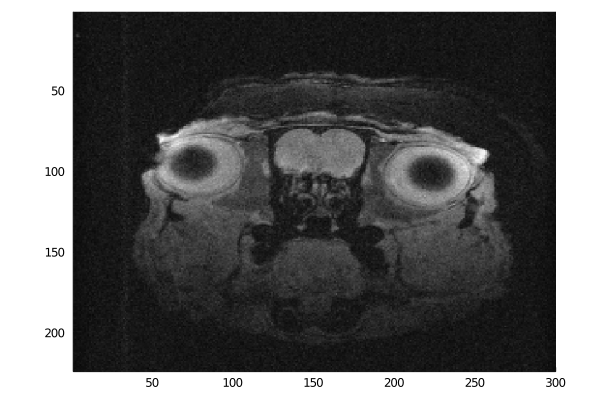

In [118]:
ssim, NMSE, plt = eval_result("measurements/trial_3/" * split(best_label[9], " ")[1] * ".jld")
@show ssim
@show NMSE
plt